# Word Embedding

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.4.1


## Download

In [2]:
import tensorflow_datasets as tfds
# imdb contains reviews, info contains meta-data.
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


## Preprocessing

In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# YH: For training we have to convert labels list into Numpy arrays.  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


## Tokenization

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
# YH: Replace sentence with indexs
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# YH: Note that the word index is words that are derived from the training set,
# so you should expect to see a lot more out of vocabulary tokens in the test sentences. 
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


## Helper function

In [5]:
# YH: To be able to plot it, we need a helper function to reverse our word index. 
# YH: Before we have "Hello: 1" in the dictionary, now reverse it to "1: Hello".
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# YH: Map index sequence to word sequence.
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
# YH: Note in the lecture video 'sceptical' becomes 'oov' because it is not in the top 10000 words.
print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


## Model

In [6]:
model = tf.keras.Sequential([
    # YH: The TensorFlow layer 'Embedding' used in NLP 
    #     with parameters vocab size, feature vector size, and input sentence size.
    #     It can simulate 'Embedding Matrix' in NLP, instead of explicit algorithms.
    #     I guess TensorFlow just projects each input word index to the matrix
    #     to obtain the particular vector, and then sum up vectors to obtain a result as input for the next layer.
    #     In training they changes vectors gradually, and in prediction they just use the vectors.
    #     If two words in the database are interchangable, they must have similar vectors.
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


## Training

In [7]:
num_epochs = 10
history = model.fit(padded, 
                    training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 6s 7ms/step - loss: 0.6042 - accuracy: 0.6410 - val_loss: 0.3465 - val_accuracy: 0.8454
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2448 - accuracy: 0.9076 - val_loss: 0.3692 - val_accuracy: 0.8400
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1114 - accuracy: 0.9726 - val_loss: 0.4396 - val_accuracy: 0.8328
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0342 - accuracy: 0.9953 - val_loss: 0.5255 - val_accuracy: 0.8282
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0142 - accuracy: 0.9983 - val_loss: 0.6054 - val_accuracy: 0.8254
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0085 - accuracy: 0.9986 - val_loss: 0.6484 - val_accuracy: 0.8269
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.7000 - val_accuracy: 0.8251
Epoch 

## Performance

<Figure size 432x288 with 0 Axes>

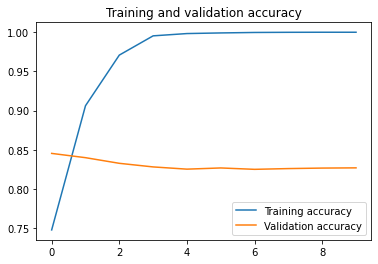

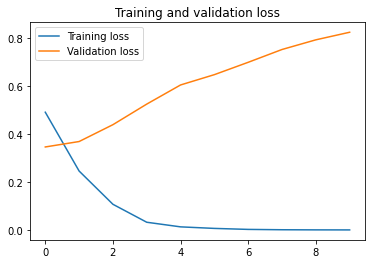

<Figure size 432x288 with 0 Axes>

In [8]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training accuracy' )
plt.plot  ( epochs, val_acc, label='Validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss')
plt.plot  ( epochs, val_loss, label='Validation loss')
plt.title ('Training and validation loss'   )
plt.legend(loc=0)
plt.figure()

## Prediction

In [19]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

model.predict(pad_sequences(sequence, maxlen=max_length, truncating=trunc_type))

[[11, 64, 102, 12, 7, 478, 1200]]


array([[0.98567677]], dtype=float32)

## Embedding Matrix

In [9]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [10]:
import io
# YH: Now it's time to write the vectors and their metadata out to files.
# The TensorFlow Projector reads this file type and uses it to plot the vectors in
# 3D space so we can visualize them. 
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# YH: Loop through the vocabulary words
for word_num in range(1, vocab_size):
  # YH: Obtain the word as a string
  word = reverse_word_index[word_num]
  # YH: Obtain the embedding for the vocabulary word.
  embeddings = weights[word_num]
  # YH: To the metadata array, we just write out the words. 
  out_m.write(word + "\n")
  # YH: To the vectors file, we simply write out the value of each of the items
  # in the array of embeddings, i.e, the co-efficient of each dimension 
  # on the vector for this word. 
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualization
Take 'vecs.tsv' and 'meta.tsv' to https://projector.tensorflow.org/ for visualization.